# **0. 대회 소개**


- [대회 링크](https://www.kaggle.com/competitions/store-sales-time-series-forecasting)
- 시계열 예측을 사용하여 에콰도르 기반의 대형 식료품 소매업체인 Corporación Favorita의 `매장 판매량`을 예측하고자 함
  - Favorita 매장에서 판매되는 수천 개 제품들의 `단위 판매량`을 제품군 별로 더 정확하게 예측하는 모델을 구축하고자 함


**평가 지표**
- Root Mean Squared Logarithmic Error(`RMSLE`)
  - 다음과 같이 계산  
  $ \sqrt{ \frac{1}{n} \sum_{i=1}^n \left(\log (1 + \hat{y}_i) - \log (1 + y_i)\right)^2} $
  - $n$: 총 인스턴스 수
  - $ \hat{y}_i$: 인스턴스 $i$에 대한 타겟의 예측값
  - $y_i$: 인스턴스 $i$에 대한 타겟의 실제값

# **1. 전처리된 데이터 불러오기**

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format # 소수점 둘째자리까지만 표시

import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train = pd.read_csv('/content/drive/MyDrive/ESAA/OB/project/방학프로젝트/data/train_preprocessed.csv')
test = pd.read_csv('/content/drive/MyDrive/ESAA/OB/project/방학프로젝트/data/test_preprocessed.csv')

In [4]:
train.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico,transactions,holiday
0,0,2013-01-01,1,AUTOMOTIVE,0.00,0.00,Quito,Pichincha,D,13,93.14,0.00,National
1,1,2013-01-01,41,SEAFOOD,0.00,0.00,Machala,El Oro,D,4,93.14,0.00,National
2,2,2013-01-01,41,SCHOOL AND OFFICE SUPPLIES,0.00,0.00,Machala,El Oro,D,4,93.14,0.00,National
3,3,2013-01-01,41,PRODUCE,0.00,0.00,Machala,El Oro,D,4,93.14,0.00,National
4,4,2013-01-01,41,PREPARED FOODS,0.00,0.00,Machala,El Oro,D,4,93.14,0.00,National


In [5]:
test.head()

,id,date,store_nbr,family,onpromotion,city,state,type,cluster,dcoilwtico,holiday
0,3000888,2017-08-16,1,AUTOMOTIVE,0,Quito,Pichincha,D,13,46.80,Weekday
1,3000889,2017-08-16,1,BABY CARE,0,Quito,Pichincha,D,13,46.80,Weekday
2,3000890,2017-08-16,1,BEAUTY,2,Quito,Pichincha,D,13,46.80,Weekday
3,3000891,2017-08-16,1,BEVERAGES,20,Quito,Pichincha,D,13,46.80,Weekday
4,3000892,2017-08-16,1,BOOKS,0,Quito,Pichincha,D,13,46.80,Weekday


# **2. EDA**

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2705087 entries, 0 to 2705086
Data columns (total 13 columns):
 #   Column        Dtype  
---  ------        -----  
 0   id            int64  
 1   date          object 
 2   store_nbr     int64  
 3   family        object 
 4   sales         float64
 5   onpromotion   float64
 6   city          object 
 7   state         object 
 8   type          object 
 9   cluster       int64  
 10  dcoilwtico    float64
 11  transactions  float64
 12  holiday       object 
dtypes: float64(4), int64(3), object(6)
memory usage: 268.3+ MB


In [7]:
train.describe()

,id,store_nbr,sales,onpromotion,cluster,dcoilwtico,transactions
count,2705087.00,2705087.00,2705087.00,2705087.00,2705087.00,2705087.00,2701309.00
mean,1352543.00,26.80,396.90,2.89,8.54,66.59,1683.18
std,780891.50,15.61,1153.98,12.84,4.73,25.49,972.75
min,0.00,1.00,0.00,0.00,1.00,26.19,0.00
25%,676271.50,13.00,1.00,0.00,4.00,46.12,1039.00
50%,1352543.00,27.00,19.00,0.00,9.00,52.71,1392.00
75%,2028814.50,40.00,239.15,0.00,13.00,95.14,2076.00
max,2705086.00,54.00,124717.00,741.00,17.00,110.62,8359.00


## **2-1. Target 변수(sales)**

In [61]:
train_copy = train.copy()

In [62]:
train_copy = train_copy.groupby('date').mean()[['sales']].reset_index()

train_copy['date'] = pd.to_datetime(train_copy['date'])
train_copy['year'] = train_copy['date'].dt.year
train_copy['month'] = train_copy['date'].dt.month
train_copy['weekofyear'] = train_copy['date'].dt.weekofyear
train_copy['day'] = train_copy['date'].dt.day
train_copy['dayofweek'] = train_copy['date'].dt.day_name()

In [63]:
train_copy.head()

,date,sales,year,month,weekofyear,day,dayofweek
0,2013-01-01,1.71,2013,1,1,1,Tuesday
1,2013-01-02,336.79,2013,1,1,2,Wednesday
2,2013-01-03,245.39,2013,1,1,3,Thursday
3,2013-01-04,240.64,2013,1,1,4,Friday
4,2013-01-05,324.07,2013,1,1,5,Saturday


(1) 일별 매출 평균

In [64]:
# 'date', 'sales', 'onpromotion' 열만 선택하여 새로운 데이터프레임 생성
train_aux = train[['date', 'sales', 'onpromotion']].groupby('date').mean()
train_aux = train_aux.reset_index()

# 산점도 그래프 생성
fig = go.Figure(data=go.Scatter(x=train_aux['date'],
                                y=train_aux['sales'],
                                marker_color='red', text="sales"))

# 그래프 레이아웃 업데이트
fig.update_layout({"title": f'전체 상점 및 제품의 날짜별 평균 판매량',
                   "xaxis": {"title":"날짜"},
                   "yaxis": {"title":"평균 판매량"},
                   "showlegend": False})

fig.show()

=> 매출이 점차 증가하는 추세이다.

=> 2015년 7월 이후 안정적인 추세를 보인다.

=> **주 단위**로 sales가 증가했다 감소하는 주기를 보인다.

(2) statsmodels로 Trend, Seasonal, Residual 살펴보기


In [65]:
df_date = train_copy[['date', 'sales']].set_index('date')
df_date.head()

,sales
date,
2013-01-01,1.71
2013-01-02,336.79
2013-01-03,245.39
2013-01-04,240.64
2013-01-05,324.07


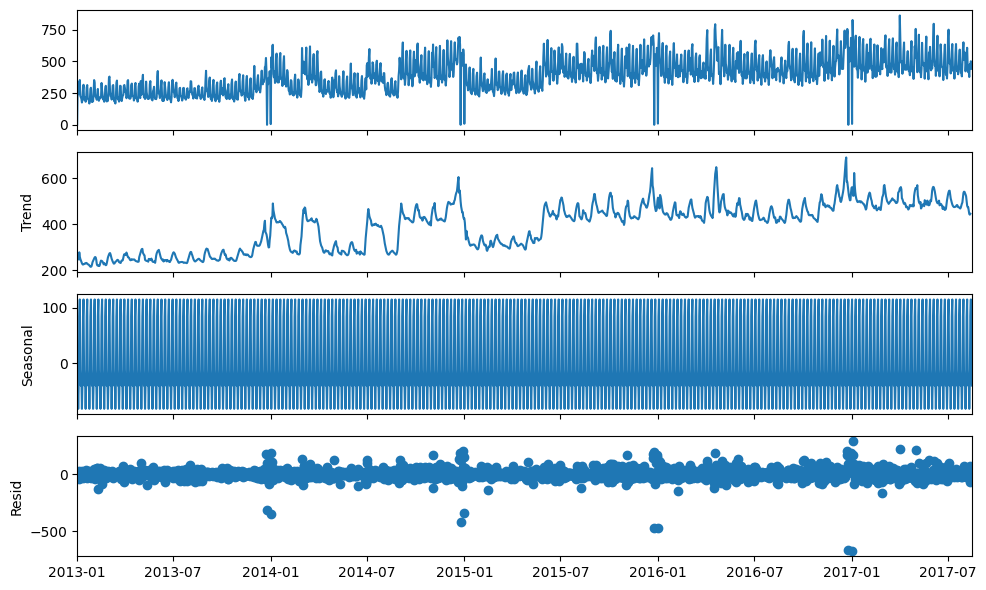

In [66]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomp= seasonal_decompose(df_date, model = 'additive')
plt.rcParams['figure.figsize'] = (10, 6)
d = decomp.plot()

=> Trend 그래프를 살펴보았을 때 장기적으로 증가하는 추세임을 알 수 있다.

=> **sesonal** 그래프가 왜저러는지는 모르겠습니다,,,

(3) ACF, PACF 플롯 그리기

In [ ]:
# pip install scalecast

In [71]:
from scalecast.Forecaster import Forecaster
import pandas_datareader as pdr

<Axes: xlabel='Date', ylabel='Values'>

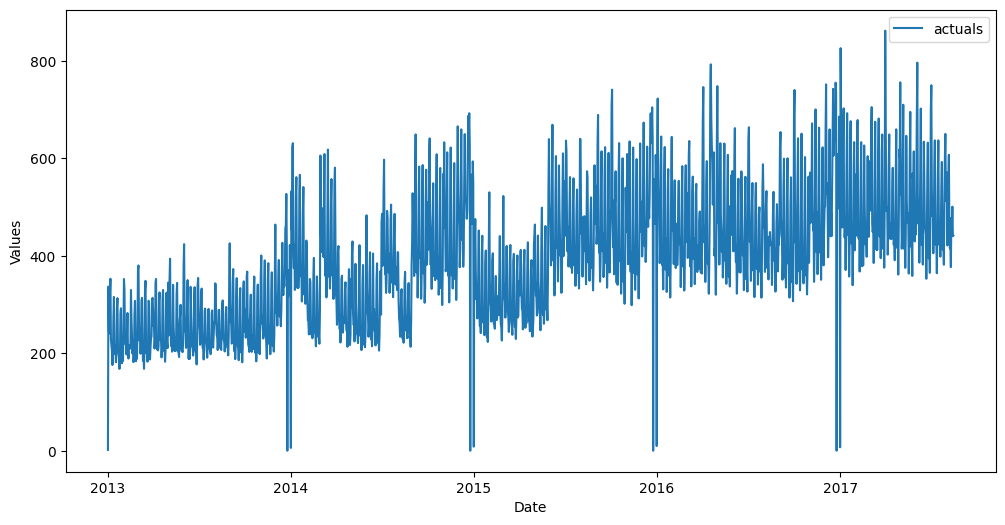

In [72]:
f = Forecaster(y=train_copy['sales'], current_dates=train_copy['date'])
f.plot()

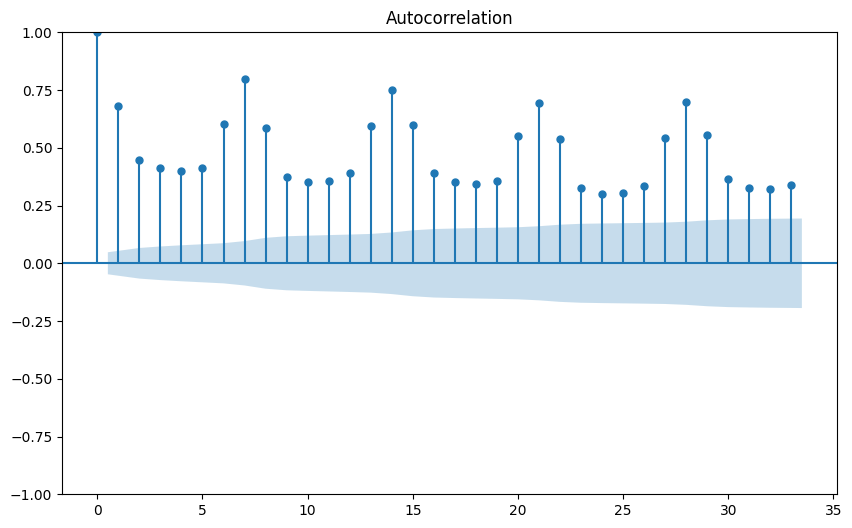

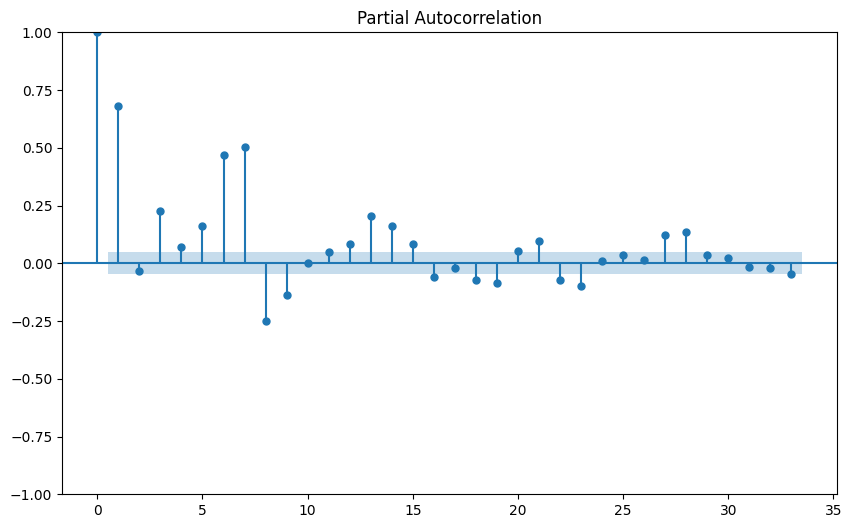

In [73]:
# ACF 플롯 / PACF 플롯
f.plot_acf()
f.plot_pacf()
plt.show()

=> y축의 값들은 ACF,PACF를 수치화한 것이고, x축이 lag되는 수 즉 몇개 전의 값에 대한 것인지 말해준다

=> 해석 쓰기

(4) 주당 매출 평균

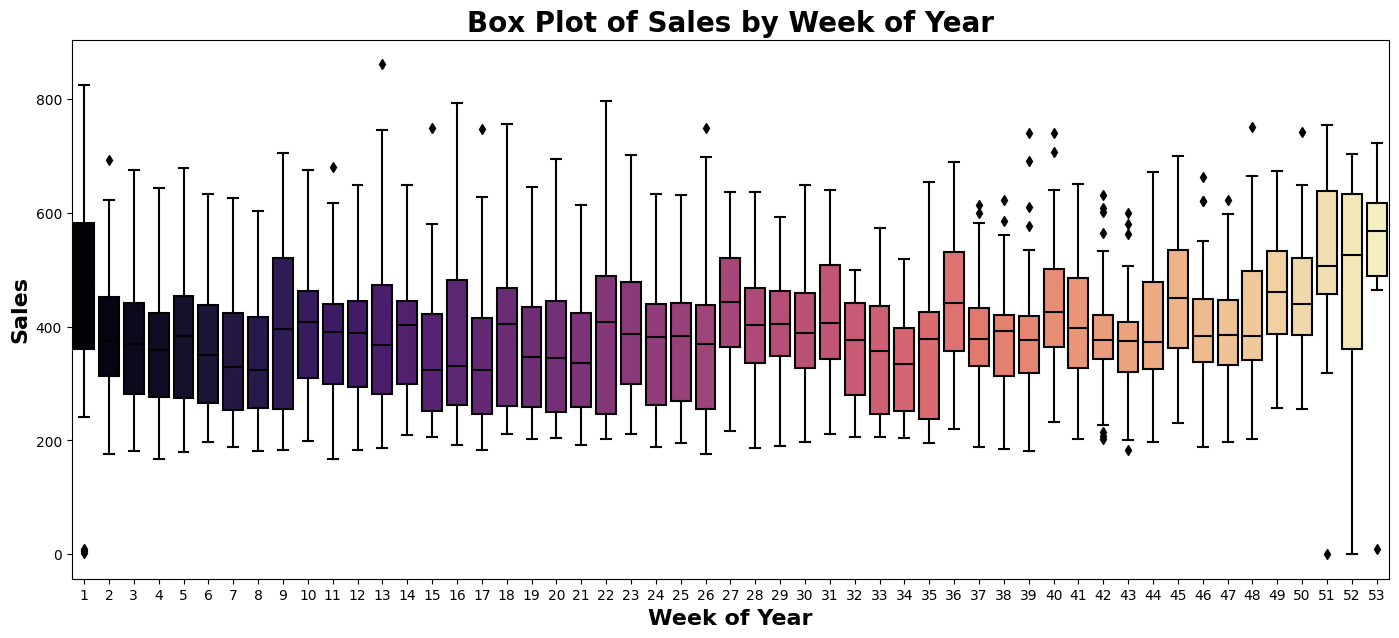

In [74]:
fig = plt.figure(figsize=(17,7))
sns.boxplot(x=train_copy['weekofyear'], y=train_copy['sales'], palette="magma")

plt.title('Box Plot of Sales by Week of Year', fontsize=20, loc='center', fontdict=dict(weight='bold'))
plt.xlabel('Week of Year', fontsize=16, fontdict=dict(weight='bold'))
plt.ylabel('Sales', fontsize=16, fontdict=dict(weight='bold'))

plt.show()

=> 각 년의 첫째주와, 마지막 3주의 매출이 가장 높다.

(5) 월별 매출 평균

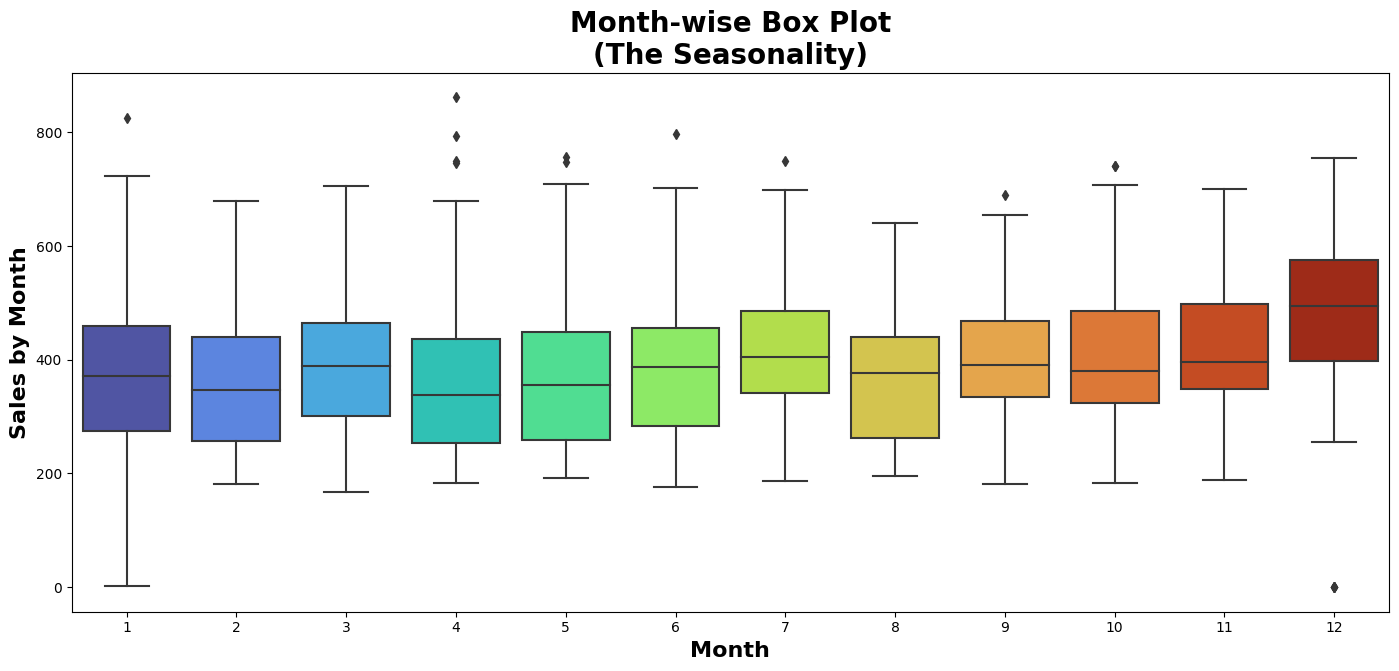

In [75]:
fig = plt.figure(figsize=(17,7))

sns.boxplot(x=train_copy['month'], y=train_copy['sales'], palette="turbo")

plt.title('Month-wise Box Plot\n(The Seasonality)', fontsize=20, loc='center', fontdict=dict(weight='bold'))
plt.xlabel('Month', fontsize=16, fontdict=dict(weight='bold'))
plt.ylabel('Sales by Month', fontsize=16, fontdict=dict(weight='bold'))

plt.show()

=> 12월의 매출이 다른 달보다 높은 편이다.

(6) 년도별 매출 평균

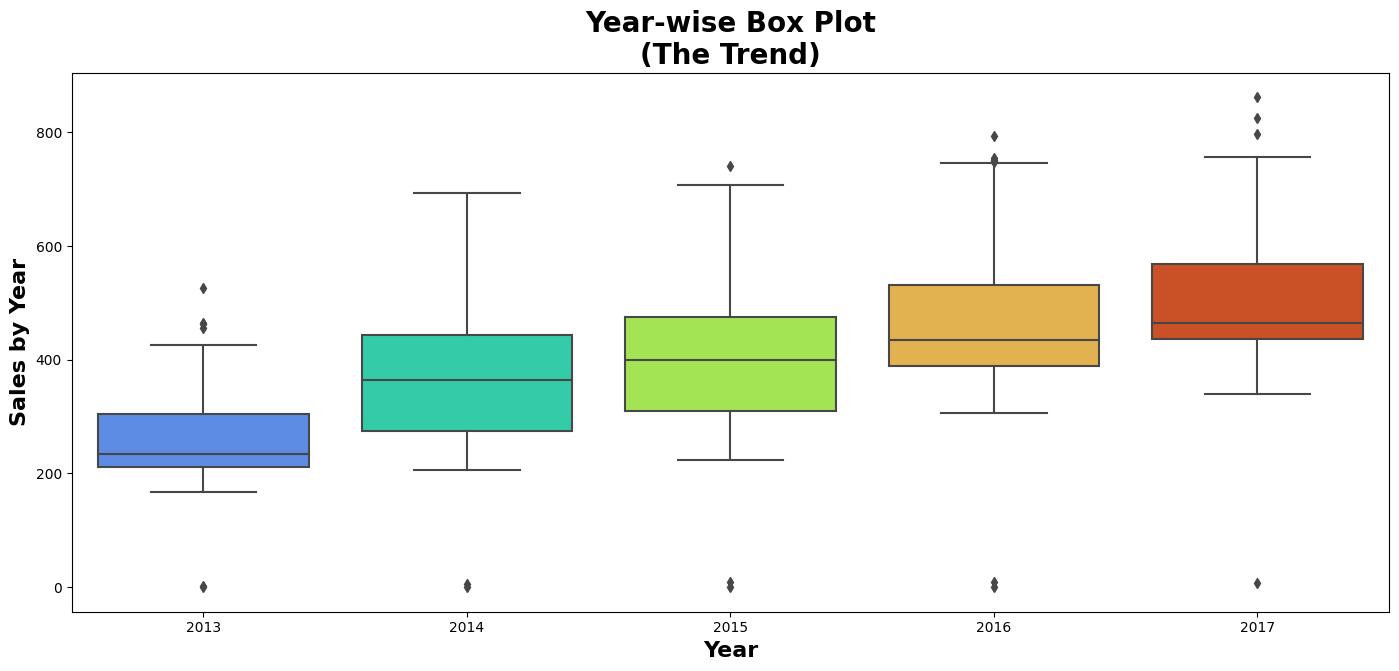

In [76]:
fig = plt.figure(figsize=(17,7))

sns.boxplot(x=train_copy['year'], y=train_copy['sales'], palette="turbo")

plt.title('Year-wise Box Plot\n(The Trend)', fontsize=20, loc='center', fontdict=dict(weight='bold'))
plt.xlabel('Year', fontsize=16, fontdict=dict(weight='bold'))
plt.ylabel('Sales by Year', fontsize=16, fontdict=dict(weight='bold'))

plt.show()

=> 년도가 지나면서 매출이 상승하고 있으며, 상승 폭은 작아지고 있다.

(7) 요일별 매출

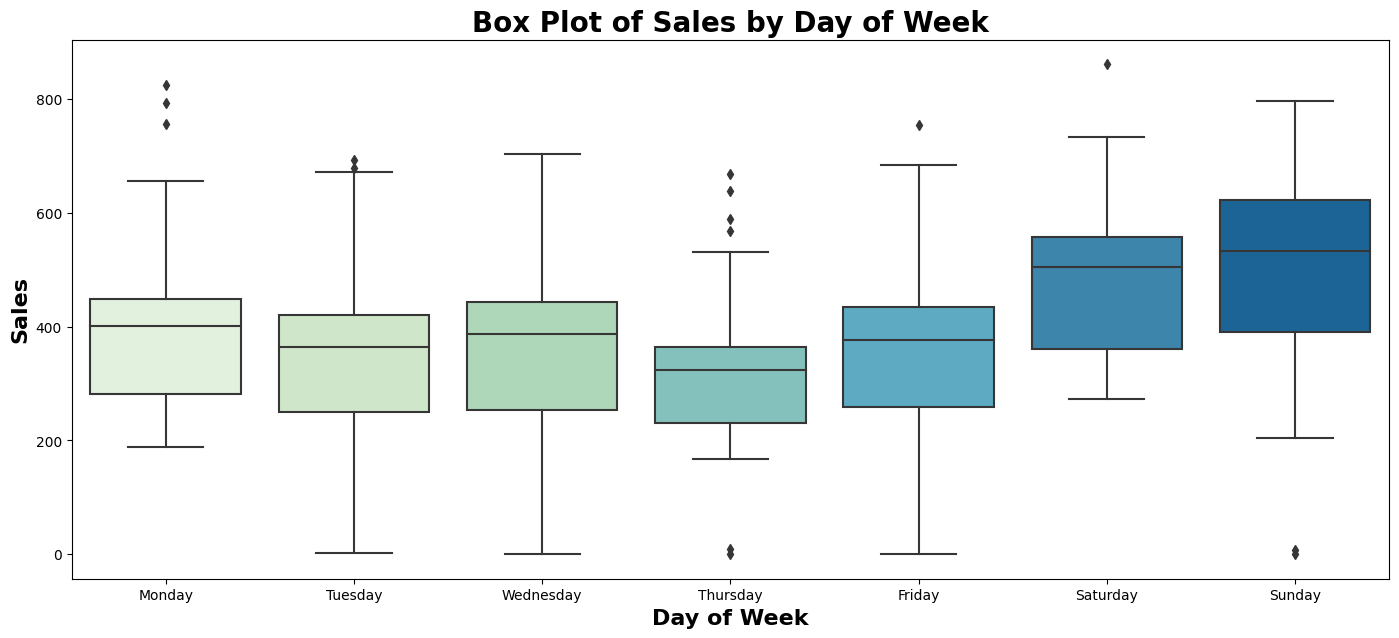

In [77]:
fig = plt.figure(figsize=(17,7))
sns.boxplot(x=train_copy['dayofweek'], y=train_copy['sales'], palette="GnBu",
            order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

plt.title('Box Plot of Sales by Day of Week', fontsize=20, loc='center', fontdict=dict(weight='bold'))
plt.xlabel('Day of Week', fontsize=16, fontdict=dict(weight='bold'))
plt.ylabel('Sales', fontsize=16, fontdict=dict(weight='bold'))

plt.show()

=> 주말에 매출이 가장 높으며, 세번째로 높은 요일은 월요일이다.

## **2-2. Feature 변수**

(1) store_nbr

In [9]:
# 그래프를 그리기 위해 store_nbr 변수의 type을 object로 변경
train['store_nbr'] = train['store_nbr'].astype(str)

In [10]:
train['store_nbr'].value_counts()

8     55704
26    55704
4     55704
27    55704
24    55704
41    55704
37    55704
3     55704
5     55704
38    55704
2     55704
6     55704
7     55704
1     54016
17    54016
15    54016
12    54016
11    54016
10    54016
31    54016
23    54016
25    54016
18    54016
19    54016
50    54016
51    54016
47    54016
49    54016
48    54016
9     54016
39    54016
45    54016
44    54016
34    54016
46    54016
33    52328
43    52328
40    52328
35    52328
32    52328
28    52328
30    52328
13    52328
14    52328
16    52328
54    50640
36    49920
53    38775
20    29280
29    27280
21    24128
42    23958
22    21664
52     3658
Name: store_nbr, dtype: int64

=> 52번 매장이 가장 최근에 오픈했으며, 그 다음은 22번, 42번 순이다.

In [13]:
# 각 store_nbr에 따른 sales 평균 비교
average_sales_by_store = train.groupby('store_nbr')['sales'].mean()

# 상위 5개와 하위 5개 추출
top_5_stores = average_sales_by_store.nlargest(5)
bottom_5_stores = average_sales_by_store.nsmallest(5)

# 결과 출력
print("Top 5 Stores:")
print(top_5_stores)

print("\nBottom 5 Stores:")
print(bottom_5_stores)

Top 5 Stores:
store_nbr
44   1149.43
45   1008.92
47    943.21
3     906.25
49    803.84
Name: sales, dtype: float64

Bottom 5 Stores:
store_nbr
32   113.74
26   139.22
30   141.07
35   146.70
10   177.98
Name: sales, dtype: float64


=> 44번, 45번, 47번, 3번 매장이 평균 sales가 높은 편이다.

=> 32번 매장의 평균 sales가 가장 작다.

(2) family

In [ ]:
## family 분포 확인
train['family'].value_counts()

AUTOMOTIVE                    84453
SEAFOOD                       84453
BREAD/BAKERY                  84453
BEAUTY                        84453
BEVERAGES                     84453
CELEBRATION                   84453
CLEANING                      84453
DAIRY                         84453
DELI                          84453
EGGS                          84453
FROZEN FOODS                  84453
GROCERY I                     84453
GROCERY II                    84453
HARDWARE                      84453
HOME AND KITCHEN I            84453
HOME AND KITCHEN II           84453
HOME APPLIANCES               84453
HOME CARE                     84453
LINGERIE                      84453
LIQUOR,WINE,BEER              84453
MAGAZINES                     84453
MEATS                         84453
PERSONAL CARE                 84453
PET SUPPLIES                  84453
PLAYERS AND ELECTRONICS       84453
POULTRY                       84453
PREPARED FOODS                84453
PRODUCE                     

In [16]:
## 매출액이 가장 높은 상위 10개 제품군 시각화
df_fa_sa = train[:train.shape[0]].groupby('family').agg({"sales" : "mean"}).reset_index().sort_values(by='sales', ascending=False)[:10]

fig = make_subplots(rows=1, cols=1,
                    specs=[[{"type": "bar"}]],
                    subplot_titles=("Top 10 Highest Product Sales"))

fig.add_trace(go.Bar(x=df_fa_sa['sales'], y=df_fa_sa['family'], name='Family', orientation='h'),row=1, col=1)

# 그래프 스타일링
fig.update_yaxes(showgrid=False, ticksuffix=' ', categoryorder='total ascending', row=1, col=1)
fig.update_xaxes(visible=False, row=1, col=1)
fig.update_layout(height=300, bargap=0.2,
                  margin=dict(b=0, r=20, l=20),
                  title_text="Top 10 Highest Product Sales",
                  template="plotly_white",
                  title_font=dict(size=15, color='#8a8d93', family="Lato, sans-serif"),
                  font=dict(color='#8a8d93'),
                  hoverlabel=dict(bgcolor="#f2f2f2", font_size=13, font_family="Lato, sans-serif"),
                  showlegend=False)

fig.show()

=> 'GROCERY I'가 압도적으로 매출액이 높으며, 그 다음으로 BEVERAGES, PRODUCE 순이다.

(3) onpromotion

In [18]:
# 'onpromotion'변수와 'sales' 변수 간의 산점도
train_aux = train[['date', 'sales', 'onpromotion']].groupby('date').mean()
train_aux = train_aux.reset_index()

fig = px.scatter(train_aux[train_aux['onpromotion'] > 0], x="onpromotion", y="sales", color='sales',
                           color_continuous_scale="earth",
                 size='sales', log_x=True, size_max=30)

fig.update_layout({"title": f'Correlation between OnPromotion and Sales (total avg sales and promotion on each day)',
                   "xaxis": {"title":"On Promotion"},
                   "yaxis": {"title":"Sales"},
                   "showlegend": False})
fig.show()

=> 산점도를 살펴보았을 때 onpromotion이 커짐에 따라 sales도 커지는 경향이 약간 보인다.

(4) city

In [20]:
train['city'].value_counts()

Quito            957680
Guayaquil        403704
Cuenca           133678
Santo Domingo    132160
Ambato           108032
Machala          108032
Latacunga        106344
Daule             55704
Loja              55704
Cayambe           54016
Salinas           54016
Babahoyo          54016
Guaranda          54016
Ibarra            54016
Quevedo           52328
Riobamba          52328
Playas            52328
Esmeraldas        52328
El Carmen         50640
Libertad          49920
Manta             42433
Puyo              21664
Name: city, dtype: int64

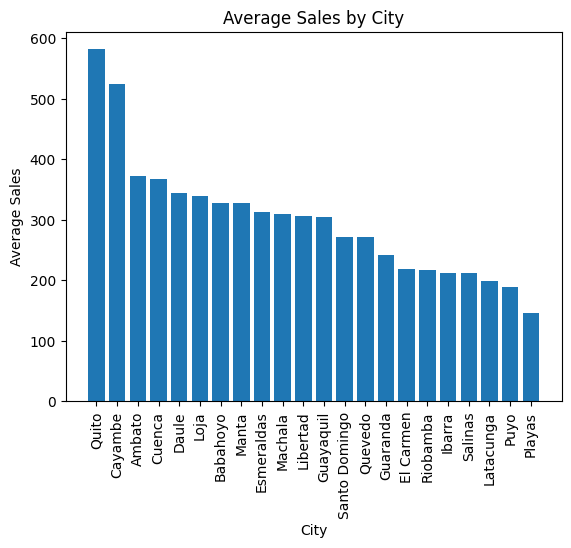

In [23]:
# 'city'별 매출액 평균 그래프
average_sales_by_city = train.groupby('city')['sales'].mean().sort_values(ascending=False)

# 그래프 그리기
plt.bar(average_sales_by_city.index, average_sales_by_city)
plt.title('Average Sales by City')
plt.xlabel('City')
plt.ylabel('Average Sales')
plt.xticks(rotation=90)
plt.show()

=> 'Quito'와 'Cayambe' 도시가 가장 매출액이 높은 편이다.

=> 'Playas'의 매출액 평균이 가장 낮은 편이며, 나머지는 비슷하다.

(5) state

In [25]:
train['state'].unique()

array(['Pichincha', 'El Oro', 'Esmeraldas', 'Guayas', 'Azuay', 'Loja',
       'Manabi', 'Tungurahua', 'Santo Domingo de los Tsachilas',
       'Los Rios', 'Bolivar', 'Imbabura', 'Cotopaxi', 'Chimborazo',
       'Santa Elena', 'Pastaza'], dtype=object)

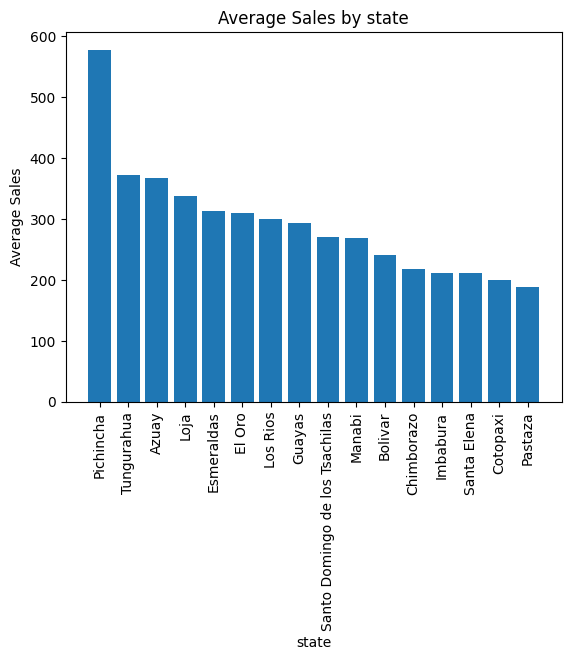

In [26]:
# 'state'별 매출액 평균 그래프
average_sales_by_state = train.groupby('state')['sales'].mean().sort_values(ascending=False)

# 그래프 그리기
plt.bar(average_sales_by_state.index, average_sales_by_state)
plt.title('Average Sales by state')
plt.xlabel('state')
plt.ylabel('Average Sales')
plt.xticks(rotation=90)
plt.show()

=> 'Pichincha' 주의 평균 매출액이 압도적으로 높다.

(6) type

In [28]:
train['type'].value_counts()

D    948933
C    761008
A    435786
B    377504
E    181856
Name: type, dtype: int64

In [36]:
# 'type'별 매출액 평균 계산 및 내림차순 정렬
average_sales_by_type = train.groupby('type')['sales'].mean().sort_values(ascending=False).reset_index()

# plotly로 그래프 그리기
fig = px.bar(average_sales_by_type, x='type', y='sales',
             title='Average Sales by Type',
             template='plotly_white',
             color='sales',
             color_continuous_scale='Viridis')

# x축 레이블 90도 회전
fig.update_xaxes(tickangle=90)

fig.show()

=> type 'A'의 평균 매출액이 800 이상으로 압도적으로 높다.

=> B, D, E의 경우 평균 매출액이 300~400 사이로 비슷하며, C가 200대로 가장 작다.

(7) cluster

In [37]:
train['cluster'].value_counts()

3     364608
10    291576
6     269472
15    268392
14    216064
13    204199
4     167112
8     167112
1     165424
11    111690
9     109720
2      79662
7      73992
5      54016
17     54016
16     54016
12     54016
Name: cluster, dtype: int64

In [43]:
# 'cluster'별 매출액 평균 계산
clusters = train.groupby('cluster')['sales'].mean().sort_values(ascending=False).reset_index()


# plotly로 그래프 그리기
fig = px.bar(clusters, x='cluster', y='sales',
             title='Average Sales by cluster',
             template='plotly_white',
             color='sales',
             text='sales',
             color_continuous_scale='Viridis')

# x축 레이블 90도 회전
fig.update_xaxes(tickangle=90)

fig.show()

=> cluster 5, 11, 14인 경우 평균 slaes가 압도적으로 높다.

=> cluster 3, 7, 11인 경우 평균 sales가 가장 낮은 편이다.

(8) dcoilwtico

In [46]:
# 'date'별 매출액 평균 계산
train_aux = train[['date', 'dcoilwtico']].groupby('date').mean()
train_aux = train_aux.reset_index()

fig = go.Figure(data=go.Scatter(x=train_aux['date'],
                                y=train_aux['dcoilwtico'],
                                marker_color='blue', text="sales"))


fig.update_layout({"title": f'Oil Prices Chart',
                   "xaxis": {"title":"Date"},
                   "yaxis": {"title":"Oil Price"},
                   "showlegend": False})

fig.show()

=> 유가 흐름을 3기로 나누어 볼 수 있다. 첫번째는 2013 ~ 2014 Jul, 두번째는 2014 Jul ~ 2015 Jan , 마지막은  2015 ~ 2017 Jul이다.

=>  첫번째와 마지막은 각각 기복이 있는 안정된 흐름을 보이고 있다. 다만, 두 번째인 Jul2014 ~ Jan2015에서는 유가가 상당히 하락하는 모습을 보인다.

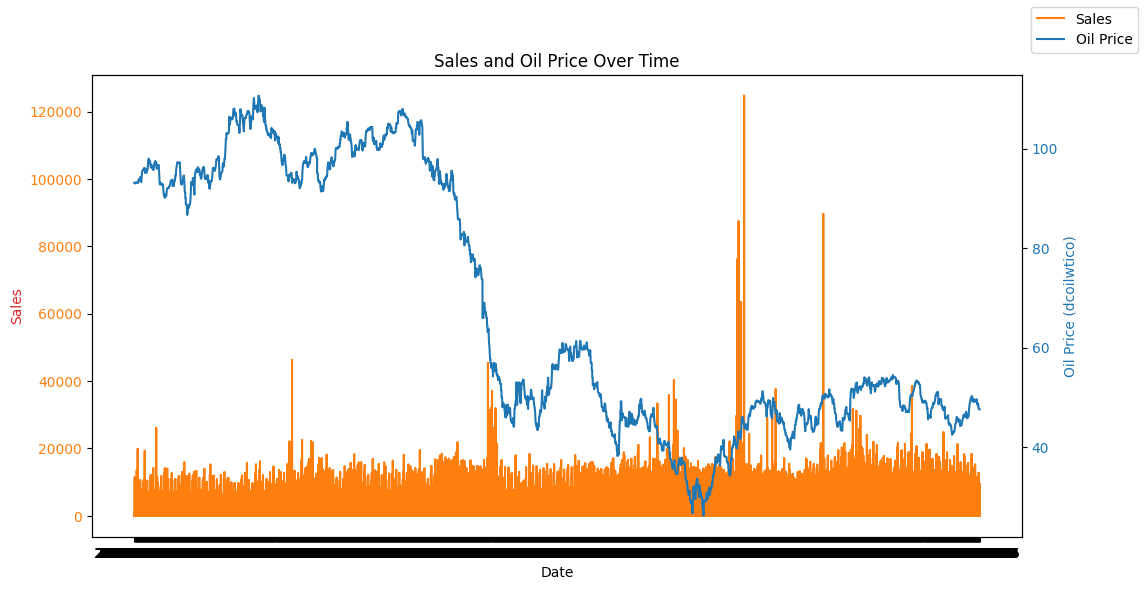

In [48]:
## sales와 oil price 간의 관계
fig, ax1 = plt.subplots(figsize=(12, 6))

# plot for sales
ax1.set_xlabel('Date')
ax1.set_ylabel('Sales', color='tab:red')
sales_line, = ax1.plot(train['date'], train['sales'], color='tab:orange', label='Sales')
ax1.tick_params(axis='y', labelcolor='tab:orange')

# plot for oil price
ax2 = ax1.twinx()
ax2.set_ylabel('Oil Price (dcoilwtico)', color='tab:blue')
oil_line, = ax2.plot(train['date'], train['dcoilwtico'], color='tab:blue', label='Oil Price')
ax2.tick_params(axis='y', labelcolor='tab:blue')

plt.title('Sales and Oil Price Over Time')
fig.legend(handles=[sales_line, oil_line], loc='upper right')
plt.show()

=> 위 그래프 상에서는 sales와 유가간의 관계가 명확히 보이지 않는다.

(9) transactions

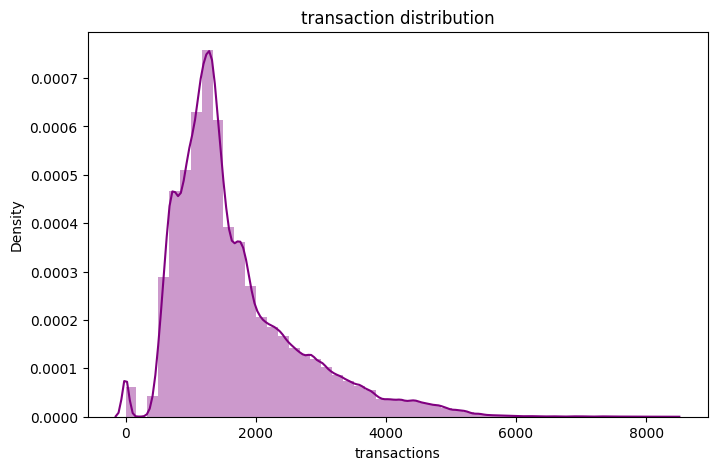

In [51]:
## 분포 시각화

plt.figure(figsize = (8,5))
plt.title("transaction distribution")
ax = sns.distplot(train["transactions"], color = 'purple')

=> 오른쪽으로 꼬리가 긴 분포를 가진다.

<Figure size 800x500 with 0 Axes>

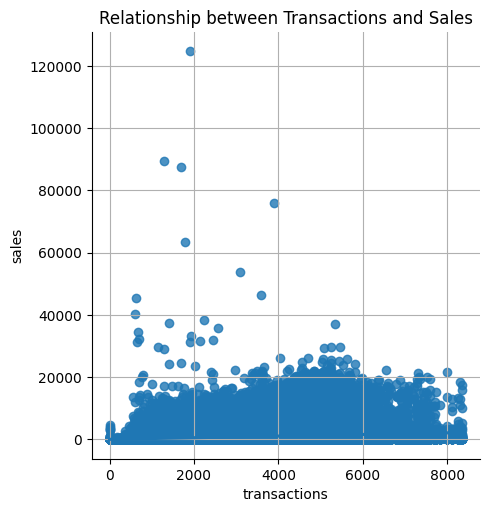

In [55]:
## transactions와 sales 간의 관계
plt.figure(figsize = (8, 5))
sns.lmplot(data = train, x = 'transactions', y = 'sales')
plt.xlabel('transactions')
plt.ylabel('sales')
plt.title('Relationship between Transactions and Sales')
plt.grid(True)
plt.show()

=> 큰 상관관계는 없어보인다.

(10) holiday

In [56]:
train['holiday'].value_counts()

Weekday     1768788
Weekend      698804
National     226288
Local         10316
Regional        891
Name: holiday, dtype: int64

In [57]:
# 'holiday'별 매출액 평균 계산
sales_by_holiday = train.groupby('holiday')['sales'].mean().sort_values(ascending=False).reset_index()


# plotly로 그래프 그리기
fig = px.bar(sales_by_holiday, x='holiday', y='sales',
             title='Average Sales by holiday',
             template='plotly_white',
             color='sales',
             text='sales',
             color_continuous_scale='Viridis')

# x축 레이블 90도 회전
fig.update_xaxes(tickangle=90)

fig.show()

=> weekend와 weekday의 격차가 큰 것으로 보인다

=> Local인 경우 평균 매출액이 큰편이며, Regional의 경우 다른 holiday에 비해서 평균 매출액이 낮은 편이다.